**Examples**

Iceball

In [1]:
try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint

from pint import UnitRegistry
units = UnitRegistry()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 4.7 MB/s eta 0:00:00


In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [3]:
from modsim import *

Vectors

In [4]:
Q = Vector(7, 8)
show(Q)

,component
x,7
y,8


In [5]:
print(Q.x)
print(Q.y)
print(Q[0])
print(Q[1])

7
8
7
8


In [6]:
P = Vector(3, 4)
print(show(Q + P))
print(show(Q - P))

   component
x         10
y         12
   component
x          4
y          4


In [7]:
from numpy import rad2deg
from numpy import deg2rad
mag = vector_mag(Q)
theta = vector_angle(Q)
angle = rad2deg(theta)
theta = deg2rad(angle)
print(mag, theta)
print(angle)
print(theta)

10.63014581273465 0.8519663271732721
48.81407483429036
0.8519663271732721


In [8]:
x, y = pol2cart(theta, mag)
R = Vector(x, y)
print(show(R))
print(show(Q / vector_mag(Q)))
Q_hat = vector_hat(Q)
print(show(Q_hat))

   component
x        7.0
y        8.0
   component
x   0.658505
y   0.752577
   component
x   0.658505
y   0.752577


Simulating Iceball Flight

In [9]:
params = Params(
    x = 0,
    y = 1,
    angle = 35,
    speed = 50,
    mass = 12e-3,
    diameter = 5e-3,
    C_d = 0.44,
    rho = 1.12,
    g = 10,
    t_end = 8,
)

In [10]:
from numpy import pi, deg2rad
def make_system(params):

    # convert angle to radians
    theta = deg2rad(params.angle)
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [11]:
system = make_system(params)
show(system.init)

,state
x,0.000000
y,1.000000
vx,40.957602
vy,28.678822


Drag Force

In [12]:
def df(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = df(V_test, system)
show(f_drag)

,component
x,-0.009908
y,-0.006937


In [13]:
def sf(t, state, system):

    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = df(V, system) / mass
    a_grav = g * Vector(0, -1)
    A = a_grav + a_drag

    return V.x, V.y, A.x, A.y
sf(0, system.init, system)

(40.95760221444959,
 28.678821817552304,
 -0.8256459892807269,
 -10.578123545586978)

Adding an Event Function

In [14]:
def ef(t, state, system):
    x, y, vx, vy = state
    return y
ef(0, system.init, system)

1.0

In [15]:
results, details = run_solve_ivp(system, sf, events=ef)
details.message

'A termination event occurred.'

In [16]:
results.tail()

,x,y,vx,vy
5.445540,212.869088,6.123480e+00,37.344163,-25.909204
5.502265,214.986312,4.638480e+00,37.305243,-26.449161
5.558989,217.101320,3.122872e+00,37.266126,-26.988382
5.615713,219.214099,1.576698e+00,37.226809,-27.526857
5.672438,221.324639,1.421085e-14,37.187290,-28.064578


In [17]:
flight_time = results.index[-1]
flight_time

5.672437707440905

In [18]:
final_state = results.iloc[-1]
show(final_state)

,5.672438
x,2.213246e+02
y,1.421085e-14
vx,3.718729e+01
vy,-2.806458e+01


In [19]:
first_distance = final_state.x
first_distance

221.32463946840718

In [20]:
final_V = Vector(final_state.vx, final_state.vy)
show(final_V)

,component
x,37.187290
y,-28.064578


In [21]:
vector_mag(final_V)

46.58878739699431

Visualizing Trajectories

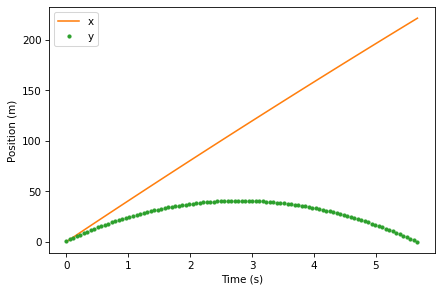

In [22]:
results.x.plot(color='C1')
results.y.plot(color='C2', style='.')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

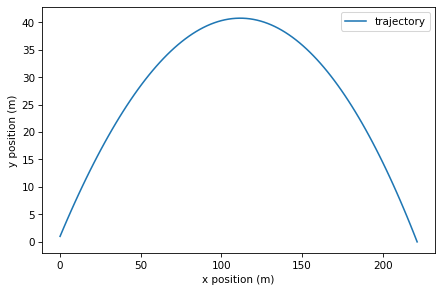

In [23]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

In [24]:
rad2deg(vector_angle(final_V))

-37.04119775166672

Animating the Iceball

In [25]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()
def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

**Exercises**

Exercise 1

In [26]:
sys2 = make_system(params.set(C_d=0))
res2, det2 = run_solve_ivp(sys2, sf, events=ef)
details.message

'A termination event occurred.'

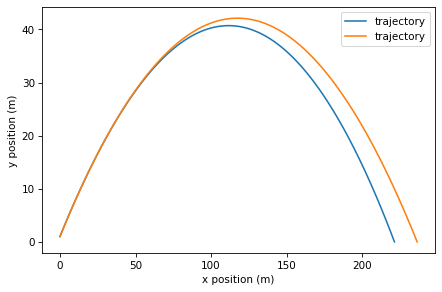

In [28]:
plot_trajectory(results)
plot_trajectory(res2)

In [29]:
second_distance = res2.iloc[-1].x
second_distance

236.34272516882027

In [30]:
second_distance - first_distance

15.018085700413081

Exercise 2

In [32]:
sys3 = make_system(params.set(rho=1.0))
res3, det3 = run_solve_ivp(sys3, sf, events=ef)

third_distance = res3.iloc[-1].x
third_distance

222.82179815302104

In [33]:
third_distance - first_distance

1.4971586846138507

Exercise 3

In [40]:
def df2(V, system):

    rho, area = system.rho, system.area
    C_d = drag_interp(vector_mag(V))
    mag = -rho * vector_mag(V)**2 * C_d * area / 2
    direction = vector_hat(V)
    f_drag = direction * mag

    return f_drag

def sf2(t, state, system):

    x, y, vx, vy = state
    mass, g = system.mass, system.g
    V = Vector(vx, vy)
    a_drag = df2(V, system) / mass
    a_grav = g * Vector(0, -1)
    A = a_grav + a_drag

    return V.x, V.y, A.x, A.y

sys4 = make_system(params)

V = Vector(25, 25)
f_drag = df(V, sys4)
show(f_drag)

,component
x,-0.004276
y,-0.004276


In [41]:
sf(0, sys4.init, sys4)

(40.95760221444959,
 28.678821817552304,
 -0.8256459892807269,
 -10.578123545586978)